In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import os
import sys
sys.path.append("../lib")
from dataUtils import *
import cPickle as pickle
import cv2
from collections import Counter

In [5]:
ClassFile = "../Logs/classes.json"

vineScores = "../Logs/sampled_vine_sentibank_final.csv"
#selfieScores = "../Logs/selfieSentibankProbs.csv"
sentibank_scores = "../Logs/sentibank_baseline_final.csv"

vinePaths = "../Logs/sampled_vine_ANPS_final.pk"
#selfiePaths = "../Logs/selfiePaths.txt"

imageNetObjs = "../Logs/sampledvineImagenetObjs2015_1.pk"

#selfiePopularityFile = "../Logs/selfie_dataset.txt"

root = "../vinedata/Data/"

visitedList = "../Logs/sampledVids.data"

# sentimentFile = "../Logs/ANP_Sentiments.txt"

color_features = "../Logs/color_features_sampled_ordered.csv"

sampled_img_list = "../Logs/sampled_sentibank_image.txt"

In [3]:
#Load the Sentibank scores for both selfies and Vines
vineProbs = np.loadtxt(vineScores, delimiter=',')

In [4]:
sentibank_baseline = np.loadtxt(sentibank_scores, delimiter=',')

In [28]:
print vineProbs.shape , sentibank_baseline.shape

(50187, 2089) (5000, 2089)


In [68]:
def get_ANP_ID_List(pickleList):
    ANPs = []
    IDs = []
    for line in pickleList:
        ids = line.split(',')[0].split('/')[5].split('_')[0]
        IDs.append(ids)
        ANPs.append(line.split(',')[1])
    return IDs , ANPs

def get_vid_senti(pickle , index):
    oldId = pickle[index].split(',')[0].split('/')[6].split('_')[0]
    seqDict = dict()
    indexList = []
    sequence = pickle[index].split(',')[0].split('/')[6].split('_')[1].split('.')[0]
    seqDict[int(sequence)] = str(pickle[index].split(',')[1])
    indexList.append(index)
    index+=1
    #print index
    while (index < len(pickle) and (pickle[index].split(',')[0].split('/')[6].split('_')[0] == oldId)):
        sequence = pickle[index].split(',')[0].split('/')[6].split('_')[1].split('.')[0]
        seqDict[int(sequence)] = str(pickle[index].split(',')[1])
        indexList.append(index)
        index += 1
    seqDict['indexList'] = indexList
    return seqDict , oldId , index
    
def get_VID_ANP_List(pickle):
    megaDict = dict()
    i = 0
    print len(pickle)
    while i < len(pickle):           
        subDict , postId , i = get_vid_senti(pickle , i)
        megaDict[int(postId)] = subDict
    return megaDict


def pruneMegaDict(megadict , filterindices):
    filteredList = dict()
    for entry in megadict:
        commns = set(megadict[entry]['indexList']).intersection(filterindices)
        if len(commns) >= 4:
            filteredList[entry] = megadict[entry]
    return filteredList


In [46]:
image_list =[]
with open(sampled_img_list) as f:
    image_list = f.readlines()

true_labels = []
for line in image_list:
    label = line.split('/')[5]
    true_labels.append(label)
    
f = open(ClassFile ,'r')
sentibankClasses = json.load(f)
f.close()

In [122]:
sentibank_probs = np.zeros(len(sentibank_baseline))
detected_labels = []
for i in range(sentibank_probs.shape[0]):
    sentibank_probs[i] = sentibank_baseline[i].max()
    detected_labels.append(str(sentibankClasses[np.argmax(sentibank_baseline[i])]))
    
print np.median(sentibank_probs), sentibank_probs.var(), sentibank_probs.mean()

0.0718716159463 0.0234088881327 0.125452709451


In [48]:
# for i in range(len(detected_labels)):
#     if detected_labels[i] == true_labels[i]:
#         print "yaay"


In [49]:
curatedProbs_index = []
for i in range(len(vineProbs)):
    if (vineProbs[i].max() > (np.median(sentibank_probs))):
        curatedProbs_index.append(i)

        
print len(curatedProbs_index)

12902


In [50]:

vineList = readLists(vinePaths)
objList = readLists(imageNetObjs)
print curatedProbs_index[5]
print objList[1]

30
/datasets/sagarj/vineData/sampledFrames/1281860887099457536_2.jpg,label,television,


In [66]:
print vineList[0].split(',')[0].split('/')[6].split('_')[0]

1281860887099457536


In [51]:
idList, anpList = get_ANP_ID_List(vineList)

In [52]:
#print idList[1000] , anpList [1000]

In [53]:
sentidict = readSentiments()
print len(vineList)

50187


In [69]:
megaDict = get_VID_ANP_List(vineList)

50187


In [ ]:
#megaDict[1281867050901532672]['indexList']

In [70]:
filteredDict = pruneMegaDict(megaDict, curatedProbs_index)

In [71]:
print len(filteredDict)

1296


In [72]:
len(megaDict)

6752

In [74]:
postIds = []
for line in vineList:
    arr = line.split('/')
    i = int(arr[6].split('_')[0])
    postIds.append(i)

In [75]:
letter_counts = Counter(postIds)

In [76]:
len(letter_counts)

6752

In [77]:
senti_matrix = np.zeros((len(filteredDict),7))
print senti_matrix.shape
postList = [1]

(1296, 7)


In [78]:
i = 0
postIdFilteredList = []
for entry in filteredDict:
    postIdFilteredList.append(entry)
    for j in range(1,8):
        if j in filteredDict[entry]:
            senti_matrix[i][j-1] = sentidict[filteredDict[entry][j]] if (filteredDict[entry][j] in sentidict) else 0.0
        else:
            senti_matrix[i][j-1] = 0.0
    i += 1

In [79]:

dirs,files = walkLevel1Dir(root)
visited = getVisited(visitedList)
selectedPosts = []
allPosts = []

for d in dirs:
    if d in visited:
        dataRoot = root + d
        popular = getPopularFile(dataRoot)
        rec = getRecords(popular)
        allPosts += rec

In [80]:
print len(allPosts)

25533


In [81]:
filteredPosts = dict()
for k in filteredDict:
    for post in allPosts:
        if post['postId'] == k:
            filteredPosts[k] = post
print len(filteredPosts)

1296


In [82]:
import random
rand_smpl = [ allPosts[i] for i in sorted(random.sample(xrange(len(allPosts)), len(filteredPosts))) ]
print len(rand_smpl)

allLikes = []
allReposts = []
allLoops = []
for rec in rand_smpl:
    allLikes.append(rec['likes']['count'])
    allReposts.append(rec['reposts']['count'])
    allLoops.append(rec['loops']['count'])

1296


In [83]:
filLikes = []
filReposts = []
filLoops = []
for k in filteredPosts:
    filLikes.append(filteredPosts[k]['likes']['count'])
    filReposts.append(filteredPosts[k]['reposts']['count'])
    filLoops.append(filteredPosts[k]['loops']['count'])

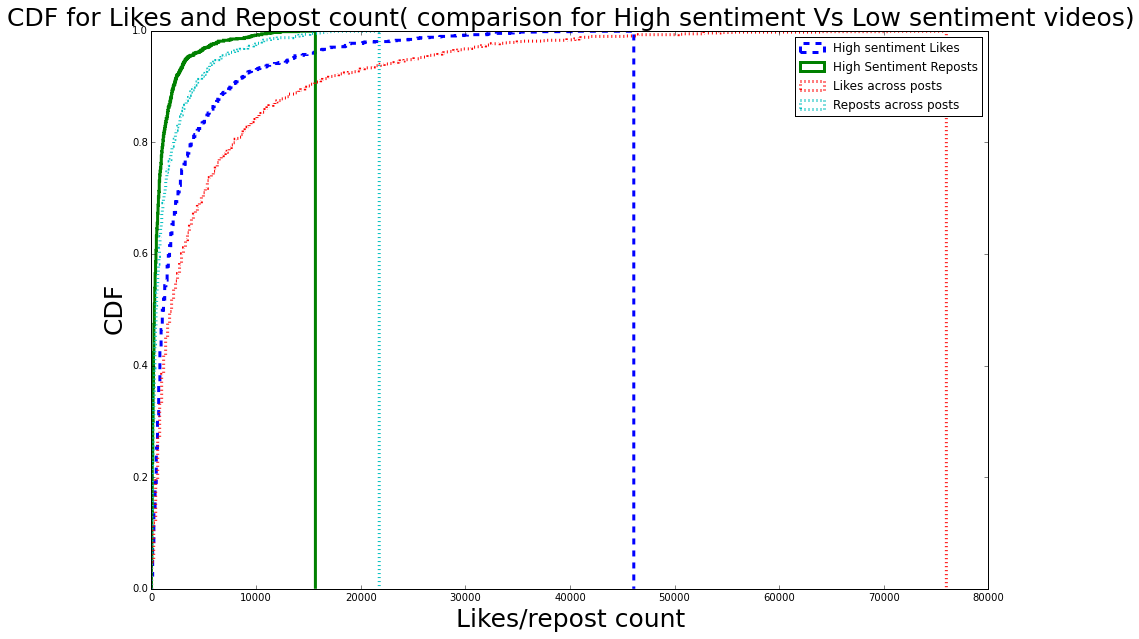

In [84]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(filLikes, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0,linestyle='dashed')
plt.hist(filReposts, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0)
plt.hist(allLikes, 400, normed=1,histtype='step', cumulative=True, linewidth = 3.0,linestyle='dotted')
plt.hist(allReposts, 400, normed=1,histtype='step', cumulative=True, linewidth = 3.0,linestyle='dotted')
plt.title("CDF for Likes and Repost count( comparison for High sentiment Vs Low sentiment videos)", fontsize = 25)
plt.xlabel("Likes/repost count",fontsize = 25)
plt.ylabel("CDF",fontsize = 25)
plt.legend(['High sentiment Likes', 'High Sentiment Reposts' , 'Likes across posts' , 'Reposts across posts'])
plt.show()


In [85]:
print np.median(filLikes)
print np.median(allLikes)

1155.5
1952.5


In [86]:
print filReposts[1:10]

[39, 926, 275, 36, 1394, 93, 376, 2291, 3271]


In [87]:
print np.corrcoef(filReposts,filLoops)
print np.corrcoef(filLikes,filLoops)
print np.corrcoef(filReposts,filLikes)

[[ 1.          0.41370206]
 [ 0.41370206  1.        ]]
[[ 1.         0.4615205]
 [ 0.4615205  1.       ]]
[[ 1.          0.93137161]
 [ 0.93137161  1.        ]]


In [88]:
# num = 133
# print vineList[num]
# print objList[num]
# print len(megaDict)
# img = cv2.imread(vineList[num].split(',')[0],1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.show()

In [89]:
print senti_matrix[1:10]

[[-1.39  1.73  1.72 -1.33  0.    0.    0.  ]
 [ 1.53  1.42  1.67  1.65  1.53  1.53  1.53]
 [ 2.    1.59  2.    1.83  1.47  1.64  1.51]
 [-0.5  -0.5  -0.5  -0.5  -0.5  -1.24  0.  ]
 [ 1.04 -1.39  1.54  1.71 -1.26 -1.55  1.1 ]
 [-2.   -2.   -2.   -2.   -2.   -2.   -2.  ]
 [ 1.66  1.66  1.66  1.66  0.    0.86  0.  ]
 [ 0.73 -0.77 -0.77  1.72  2.    1.52  1.72]
 [ 0.    0.    0.    0.64  0.64  0.    0.  ]]


In [90]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import minkowski

In [91]:
centroid_list = []
id_list = []
for i in range(1 , 12):
    centroids,_ = kmeans(senti_matrix,i)
    idx,_ = vq(senti_matrix,centroids)
    centroid_list.append(centroids)
    id_list.append(idx)

In [92]:
SSE_values = np.zeros(len(id_list))
for i in range(len(centroid_list)):
    for j in range(len(centroid_list[i])):
        vecs = senti_matrix[id_list[i]==j,:]
        #print vecs.shape
        cent = centroid_list[i][j]
        SSE_1 = 0.0
        for vec in vecs:
            SSE_1 = SSE_1 + minkowski(vec,cent,2)
        SSE_values[j] = SSE_values[j] + SSE_1
for i in range(len(SSE_values)):
    SSE_values[i] = SSE_values[i]/(i+1)

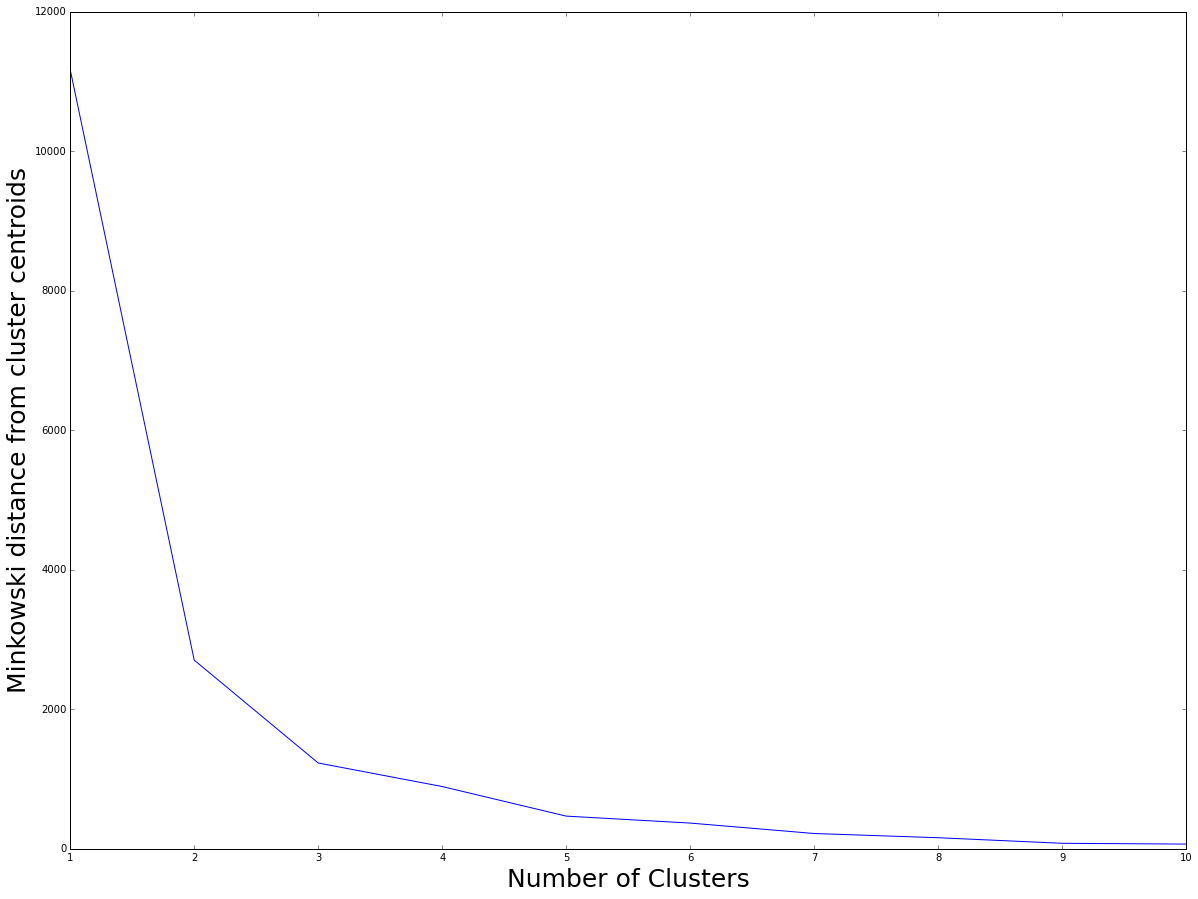

In [93]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
x = np.arange(1,11)
plt.plot(x,SSE_values[:10])
plt.xlabel("Number of Clusters", fontsize = 25)
plt.ylabel("Minkowski distance from cluster centroids", fontsize = 25)
plt.show()

In [94]:
print SSE_values

[ 11171.50083078   2705.4719025    1230.25297814    892.54707261
    468.61325757    368.83331175    219.29348974    158.73135493
     79.02689057     67.39585557     31.25429812]


In [224]:
centroid_final,_ = kmeans(senti_matrix,3)
idx_final,_ = vq(senti_matrix,centroid_final)

In [225]:
print centroid_final

[[ 0.26927203  0.27469349  0.39411877  0.38942529  0.28164751  0.19494253
   0.39856322]
 [ 1.37331984  1.38623482  1.41145749  1.39006073  1.36261134  1.25876518
   1.1688664 ]
 [-0.76564286 -0.76360714 -1.01264286 -1.05828571 -0.79742857 -0.67892857
  -0.55935714]]


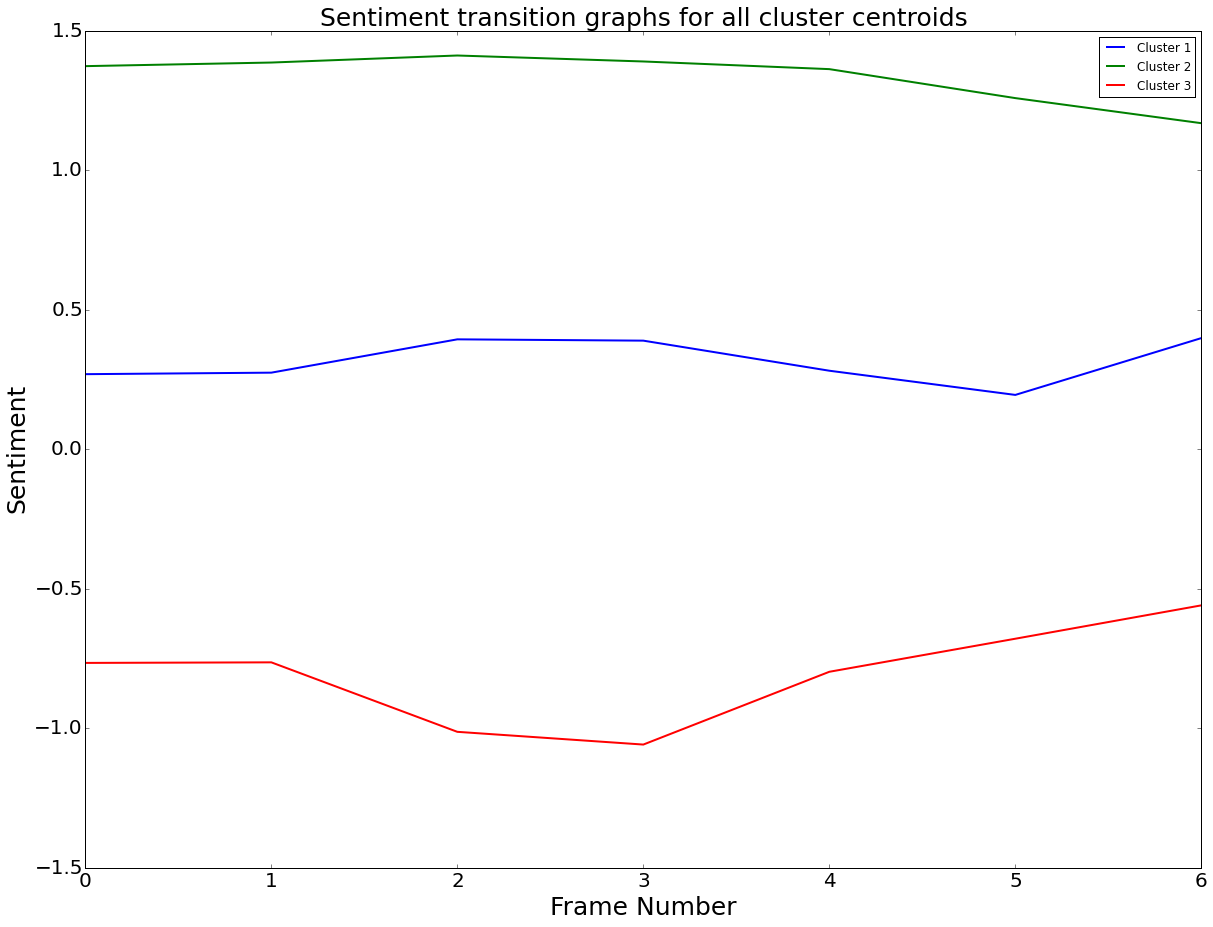

In [226]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Sentiment transition graphs for all cluster centroids", fontsize = 25)
plt.plot(centroid_final[0], linewidth = 2.0)
plt.plot(centroid_final[1], linewidth = 2.0)
plt.plot(centroid_final[2], linewidth = 2.0)
# plt.plot(centroid_final[3], linewidth = 2.0)
# plt.plot(centroid_final[4], linewidth = 2.0)
plt.xlabel("Frame Number", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Cluster 1', 'Cluster 2' , 'Cluster 3' 
            #, 'Cluster 4'
            #, 'Cluster 5'
           ])
plt.show()

senti_matrix = np.random.rand(1000,2)
centroid_list = []
id_list = []
for i in range(1 , 10):
    centroids,_ = kmeans(senti_matrix,i)
    idx,_ = vq(senti_matrix,centroids)
    centroid_list.append(centroids)
    id_list.append(idx)

SSE_values = np.zeros(len(id_list))
for i in range(len(centroid_list)):
    for j in range(len(centroid_list[i])):
        vecs = senti_matrix[id_list==j,:]
        cent = centroid_list[i][j]
        SSE_1 = 0.0
        for vec in vecs:
            SSE_1 = SSE_1 + minkowski(vec,cent,2)
        SSE_values[j] = SSE_values[j] + (SSE_1/len(vecs))
        
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.plot(SSE_values)
plt.xlabel("Number of Clusters", fontsize = 25)
plt.ylabel("Minkowski distance from cluster centroids", fontsize = 25)
plt.show()

In [227]:
def filterCluster(postids , posts , postDict, clusterMems , clusterId ):
    plist = []
    ANP_list = []
    selective = clusterMems == clusterId
    ids = [i for (i, v) in zip(postids, selective) if v]
    for postid in ids:
        plist.append(posts[postid])
        ANP_list.append(postDict[postid])
    return plist , ANP_list

def likesRepostsLoops(cluster):
    likes = np.zeros(len(cluster))
    reposts = np.zeros(len(cluster))
    loops = np.zeros(len(cluster))
    for i in range(len(cluster)):
        likes[i] = cluster[i]['likes']['count']
        reposts[i] = cluster[i]['reposts']['count']
        loops[i] = cluster[i]['loops']['count']
    return likes, reposts, loops


In [228]:
cluster1 , ANP_cluster1 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,0)
print len(cluster1)
cluster2 , ANP_cluster2 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,1)
print len(cluster2)
cluster3 , ANP_cluster3 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,2)
print len(cluster3)
# cluster4 , ANP_cluster4 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,3)
# print len(cluster4)
# cluster5 , ANP_cluster5 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,idx_final,4)
# print len(cluster5)

522
495
279


In [250]:
likesC1 , repostsC1 , loopsC1 = likesRepostsLoops(cluster1)
likesC2 , repostsC2 , loopsC2 = likesRepostsLoops(cluster2)
likesC3 , repostsC3 , loopsC3 = likesRepostsLoops(cluster3)
# likesC4 , repostsC4 , loopsC4 = likesRepostsLoops(cluster4)
# likesC5 , repostsC5 , loopsC5 = likesRepostsLoops(cluster5)

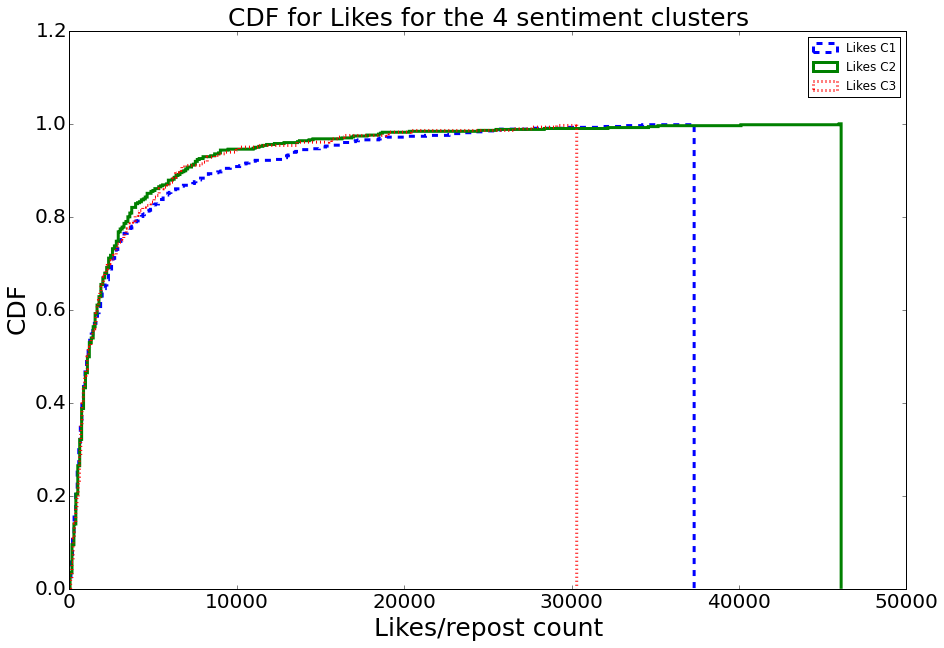

In [251]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(likesC1, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0,linestyle='dashed')
plt.hist(likesC2, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0)
plt.hist(likesC3, 400, normed=1,histtype='step', cumulative=True, linewidth = 3.0,linestyle='dotted')
# plt.hist(likesC4, 400, normed=1,histtype='step', cumulative=True, linewidth = 3.0,linestyle='dotted')
# plt.hist(likesC5, 400, normed=1,histtype='step', cumulative=True, linewidth = 3.0,linestyle='dotted')
plt.title("CDF for Likes for the 4 sentiment clusters ", fontsize = 25)
plt.xlabel("Likes/repost count",fontsize = 25)
plt.ylabel("CDF",fontsize = 25)
plt.legend(['Likes C1', 'Likes C2' , 'Likes C3' , 'Likes C4'])
plt.show()

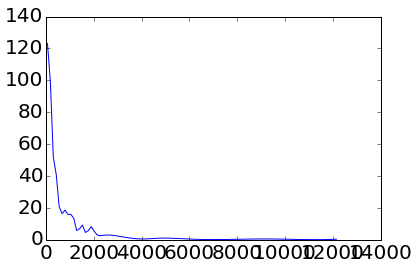

In [254]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

N = 1000
n = N/10
s = np.random.normal(size=N)   # generate your data sample with N elements
p, x = np.histogram(repostsC1, bins=n) # bin it into n = N/10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()

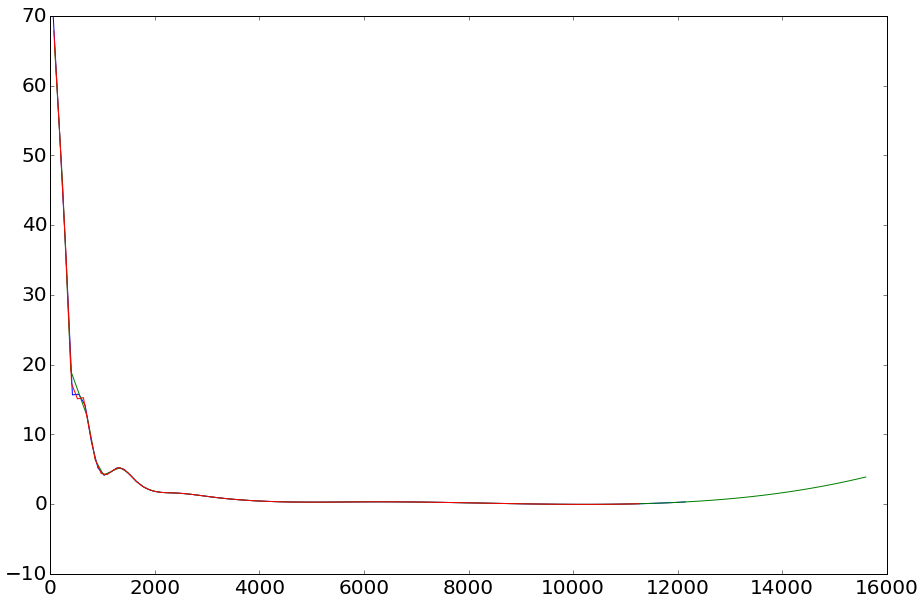

In [255]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
N = 1000
n = N/10
p, x1 = np.histogram(repostsC1, bins=n) # bin it into n = N/10 bins
p, x2 = np.histogram(repostsC2, bins=n) # bin it into n = N/10 bins
p, x3 = np.histogram(repostsC3, bins=n) # bin it into n = N/10 bins
x1 = x1[:-1] + (x1[1] - x1[0])/2   # convert bin edges to centers
x2 = x2[:-1] + (x2[1] - x2[0])/2   # convert bin edges to centers
x3 = x3[:-1] + (x3[1] - x3[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x1, f(x1))
plt.plot(x2, f(x2))
plt.plot(x3, f(x3))
plt.show()

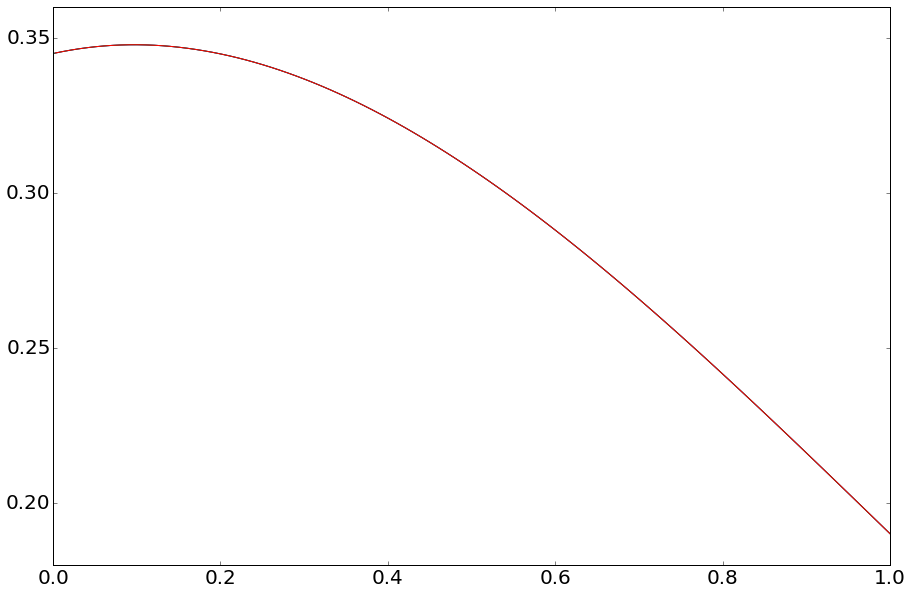

In [249]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
N = 1000
n = N/10
p, x1 = np.histogram(likesC1, bins=n) # bin it into n = N/10 bins
p, x2 = np.histogram(likesC2, bins=n) # bin it into n = N/10 bins
p, x3 = np.histogram(likesC3, bins=n) # bin it into n = N/10 bins
#x1 = x1[:-1] + (x1[1] - x1[0])/2   # convert bin edges to centers
#x2 = x2[:-1] + (x2[1] - x2[0])/2   # convert bin edges to centers
#x3 = x3[:-1] + (x3[1] - x3[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x1, f(x1))
plt.plot(x2, f(x2))
plt.plot(x3, f(x3))
plt.show()

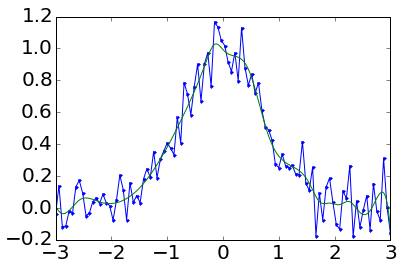

In [246]:
from numpy import linspace,exp
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
x = linspace(-3, 3, 100)
y = exp(-x**2) + randn(100)/10
s = UnivariateSpline(x, y, s=1)
xs = linspace(-3, 3, 1000)
ys = s(xs)
plt.plot(x, y, '.-')
plt.plot(xs, ys)
plt.show()

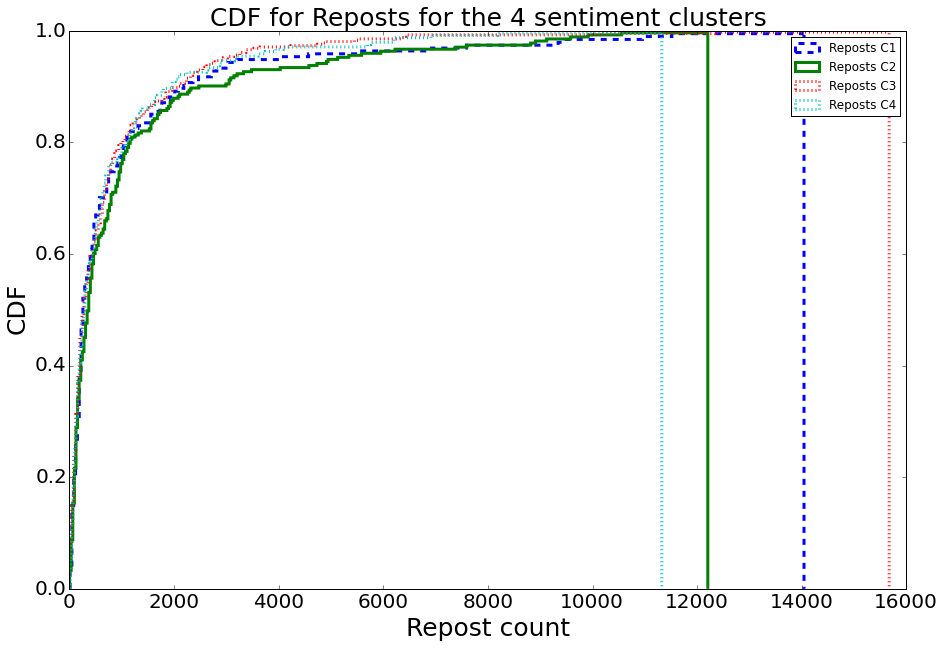

In [217]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.hist(repostsC1, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0,linestyle='dashed')
plt.hist(repostsC2, 400, normed=1,histtype='step', cumulative=True,linewidth = 3.0)
plt.hist(repostsC3, 400, normed=1,histtype='step', cumulative=True, linewidth = 3.0,linestyle='dotted')
plt.hist(repostsC4, 400, normed=1,histtype='step', cumulative=True, linewidth = 3.0,linestyle='dotted')
plt.title("CDF for Reposts for the 4 sentiment clusters ", fontsize = 25)
plt.xlabel("Repost count",fontsize = 25)
plt.ylabel("CDF",fontsize = 25)
plt.legend(['Reposts C1', 'Reposts C2' , 'Reposts C3' , 'Reposts C4'])
plt.show()

In [156]:
print "Numbers for Cluster C1: Median Reposts: %d , Mean Reposts: %d , Median Likes: %d , \
Mean Likes: %d , Median Loops: %d , Mean Loops \
%d"%(np.median(repostsC1),np.mean(repostsC1),np.median(likesC1),np.mean(likesC1),np.median(loopsC1),np.mean(loopsC1))

print "Numbers for Cluster C2: Median Reposts: %d , Mean Reposts: %d , Median Likes: %d , \
Mean Likes: %d , Median Loops: %d , Mean Loops \
%d"%(np.median(repostsC2),np.mean(repostsC2),np.median(likesC2),np.mean(likesC2),np.median(loopsC2),np.mean(loopsC2))

print "Numbers for Cluster C3: Median Reposts: %d , Mean Reposts: %d , Median Likes: %d , \
Mean Likes: %d , Median Loops: %d , Mean Loops \
%d"%(np.median(repostsC3),np.mean(repostsC3),np.median(likesC3),np.mean(likesC3),np.median(loopsC3),np.mean(loopsC3))

print "Numbers for Cluster C4: Median Reposts: %d , Mean Reposts: %d , Median Likes: %d , \
Mean Likes: %d , Median Loops: %d , Mean Loops \
%d"%(np.median(repostsC4),np.mean(repostsC4),np.median(likesC4),np.mean(likesC4),np.median(loopsC4),np.mean(loopsC4))

print "Numbers for Cluster C5: Median Reposts: %d , Mean Reposts: %d , Median Likes: %d , \
Mean Likes: %d , Median Loops: %d , Mean Loops \
%d"%(np.median(repostsC5),np.mean(repostsC5),np.median(likesC5),np.mean(likesC5),np.median(loopsC5),np.mean(loopsC5))

Numbers for Cluster C1: Median Reposts: 281 , Mean Reposts: 973 , Median Likes: 1111 , Mean Likes: 3173 , Median Loops: 46674 , Mean Loops 156085
Numbers for Cluster C2: Median Reposts: 375 , Mean Reposts: 1055 , Median Likes: 1223 , Mean Likes: 3694 , Median Loops: 42525 , Mean Loops 141306
Numbers for Cluster C3: Median Reposts: 288 , Mean Reposts: 793 , Median Likes: 1189 , Mean Likes: 2856 , Median Loops: 37868 , Mean Loops 123953
Numbers for Cluster C4: Median Reposts: 298 , Mean Reposts: 793 , Median Likes: 1233 , Mean Likes: 2920 , Median Loops: 38697 , Mean Loops 113403
Numbers for Cluster C5: Median Reposts: 282 , Mean Reposts: 822 , Median Likes: 1036 , Mean Likes: 2805 , Median Loops: 38345 , Mean Loops 99757


In [197]:
print np.std(repostsC1) , np.std(repostsC2), np.std(repostsC3), np.std(repostsC4), np.std(repostsC5)

print np.std(likesC1) , np.std(likesC2), np.std(likesC3), np.std(likesC4), np.std(likesC5)

1989.0064813 1904.932784 1463.50368356 1381.78487805 1422.22253795
5693.38359599 6290.31296806 4678.32444995 4603.2935986 4477.31939655


In [157]:
print senti_matrix[52]
print postIdFilteredList[52]
print filteredDict[postIdFilteredList[52]]
#print filteredPosts[postIdFilteredList[52]]

[ 1.65 -1.35  1.7   2.    0.    1.61  1.58]
1283180650123624448
{1: 'bright_city', 2: 'lonely_island', 3: 'playful_kitten', 4: 'sweet_puppy', 5: 'horizontal_text', 6: 'funny_guy', 7: 'healthy_adult', 8: 'wet_hair', 'indexList': [6297, 6298, 6299, 6300, 6301, 6302, 6303, 6304]}


In [183]:
import io
import base64
from IPython.display import HTML

num = 23
url = cluster5[num]['videoDashUrl'].strip().split('/')[-1].split('?')[0]
print  cluster5[num]['videoDashUrl']
print ANP_cluster5[num]

#print url
videoPath = "/datasets/sagarj/vineData/Dataset/Videos/" + url
print videoPath


video = io.open(videoPath, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

http://mtc.cdn.vine.co/r/videos_dashhd/A38CA89F5A1294815914516258816_45e58e9717c.5.0.6426022671915829626.mp4?versionId=xbjeY02rAbgNxwRM7mz7EYCprbXIDr.k
{1: 'nice_hat', 2: 'crazy_hat', 3: 'silly_hat', 4: 'crazy_hat', 5: 'funny_hat', 6: 'fluffy_snow', 7: 'fluffy_snow', 8: 'wet_snow', 'indexList': [49887, 49888, 49889, 49890, 49891, 49892, 49893, 49894]}
/datasets/sagarj/vineData/Dataset/Videos/A38CA89F5A1294815914516258816_45e58e9717c.5.0.6426022671915829626.mp4


In [184]:
def readFeatures(lines):
    ids = []
    features = []
    feats = []
    
    components = lines[0].strip().split(',')
    ID = components[0].split('/')[1].strip().split('_')[0]
    
    for line in lines:
        components = line.strip().split(',')
        postId = components[0].split('/')[1].strip().split('_')[0]
        if postId != ID:
            ids.append(postId)
            ID = postId
            features.append(np.mean(feats,0))
            feats[:] = []
            feats.append([float(x) for x in components[1:]]) 
        else :
            feats.append([float(x) for x in components[1:]]) 
            
    return features, ids
    

In [185]:
with open(color_features) as g:
        featureLines = g.readlines()
        

In [186]:
featureLines[6].strip().split(',')[1:]

['162.46225260416668',
 '34.677327068765088',
 '255',
 '0',
 '47.089047309027777',
 '31.975126394535906',
 '255.0',
 '4.5',
 '62.284151177181343',
 '34.677327068765088',
 '0.965060865488602']

In [187]:
features , posts = readFeatures(featureLines)

In [188]:
print len(posts) , len(features)

6751 6751


In [189]:
aes_features = np.asarray(features)
print aes_features.shape

(6751, 11)


In [190]:
aes_centroid_list = []
aes_id_list = []
for i in range(1 , 12):
    centroids,_ = kmeans(aes_features,i)
    idx,_ = vq(aes_features,centroids)
    aes_centroid_list.append(centroids)
    aes_id_list.append(idx)

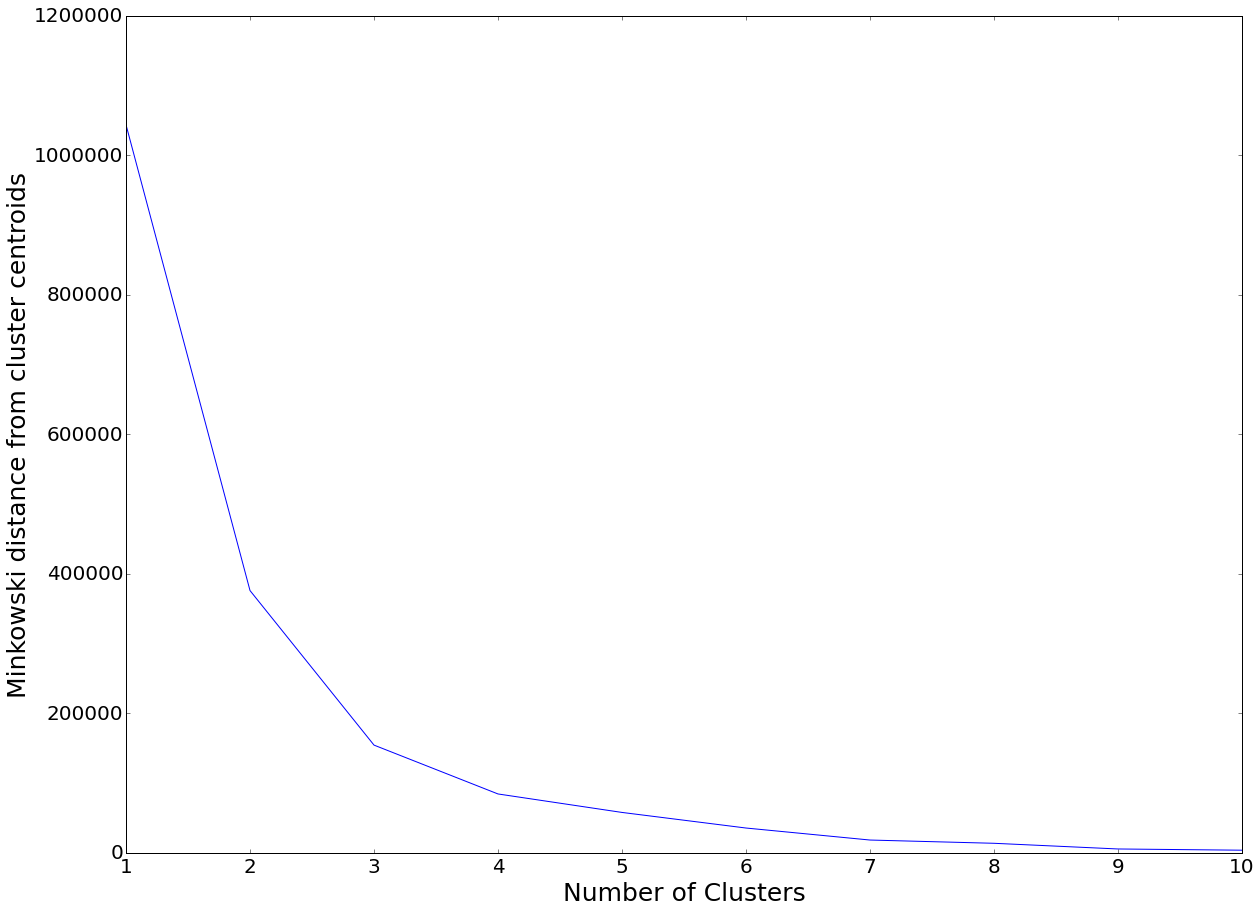

In [191]:

SSE_values = np.zeros(len(aes_id_list))
for i in range(len(aes_centroid_list)):
    for j in range(len(aes_centroid_list[i])):
        vecs = aes_features[aes_id_list[i]==j,:]
        #print vecs.shape
        cent = aes_centroid_list[i][j]
        SSE_1 = 0.0
        for vec in vecs:
            SSE_1 = SSE_1 + minkowski(vec,cent,2)
        SSE_values[j] = SSE_values[j] + SSE_1
for i in range(len(SSE_values)):
    SSE_values[i] = SSE_values[i]/(i+1)

fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
x = np.arange(1,11)
plt.plot(x,SSE_values[:10])
plt.xlabel("Number of Clusters", fontsize = 25)
plt.ylabel("Minkowski distance from cluster centroids", fontsize = 25)
plt.title("")
plt.show()

In [192]:
aes_centroid_final,_ = kmeans(aes_features,4)
aes_idx_final,_ = vq(aes_features,aes_centroid_final)

In [193]:
aes_cluster1 , ANP_cluster1 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,aes_idx_final,0)
print len(aes_cluster1)
aes_cluster2 , ANP_cluster2 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,aes_idx_final,1)
print len(aes_cluster2)
aes_cluster3 , ANP_cluster3 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,aes_idx_final,2)
print len(aes_cluster3)
aes_cluster4 , ANP_cluster4 = filterCluster(postIdFilteredList,filteredPosts,filteredDict,aes_idx_final,3)
print len(aes_cluster4)

236
342
433
285


In [194]:
import io
import base64
from IPython.display import HTML

num = 50
url = aes_cluster4[num]['videoDashUrl'].strip().split('/')[-1].split('?')[0]
print  aes_cluster4[num]['videoDashUrl']
print ANP_cluster4[num]
#print url
videoPath = "/datasets/sagarj/vineData/Dataset/Videos/" + url
#print videoPath


video = io.open(videoPath, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

http://v.cdn.vine.co/r/videos_h264dash/35A97E78141292624381440339968_48dc4146439.5.0.1606313888525775251.mp4?versionId=WicMjdsj5mKNdsjdYXd2d.XEpJWc2pM1
{1: 'horizontal_text', 2: 'horizontal_text', 3: 'horizontal_text', 4: 'horizontal_text', 5: 'horizontal_text', 'indexList': [38886, 38887, 38888, 38889, 38890]}


In [ ]:
print aes_centroid_final